In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import json


In [2]:
df=pd.read_excel('31794000.xlsx', engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:

df['price']= df['Quantity']*df['UnitPrice']
df.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1         536365     71053                  WHITE METAL LANTERN       6.0   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS      12.0   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL        6.0   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL        4.0   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE       4.0   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT        3.0   

               InvoiceDate  UnitPrice  Custom

In [4]:
today = datetime.strptime('2015-01-31', '%Y-%m-%d')

In [9]:
agg_dict1 = {
    'InvoiceNo': 'count',
    'InvoiceDate': 'max',
    'price': 'sum'
}
df_rfm = df.groupby('CustomerID').agg(agg_dict1).reset_index()
df_rfm.columns = ['CustomerID', 'frequency', 'max_date', 'monetary']
df_rfm['recency'] = (today - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis=1, inplace=True)
df_rfm.head

<bound method NDFrame.head of       CustomerID  frequency  monetary  recency
0        12347.0         89   2230.93     1150
1        12348.0         20   1202.80     1223
2        12349.0         73   1757.55     1166
3        12352.0         47    944.23     1184
4        12356.0          2     58.35     1170
...          ...        ...       ...      ...
3223     18277.0          8    110.38     1206
3224     18278.0          9    173.90     1221
3225     18282.0          5     77.84     1155
3226     18283.0        309    974.21     1151
3227     18287.0         41   1072.00     1190

[3228 rows x 4 columns]>

In [10]:
r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

df_rfm['r_score'] = pd.qcut(df_rfm['recency'], q=5, labels=r_labels).astype(int)
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'], q=5, labels=f_labels).astype(int)
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], q=5, labels=m_labels).astype(int)

df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [11]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [12]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'new customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'about to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'at risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'hibernating')

In [ ]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(df_rfm[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

In [ ]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

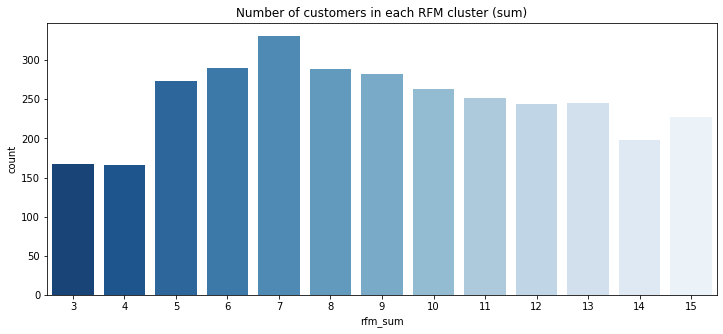

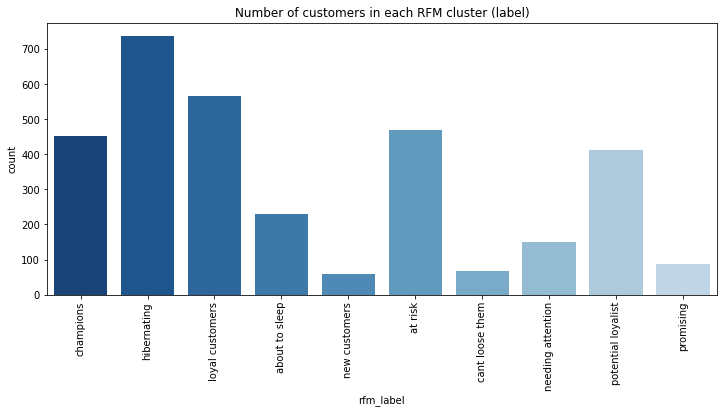

In [15]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['sum', 'label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

In [17]:
agg_dict2 = {
    'CustomerID': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'CustomerID': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

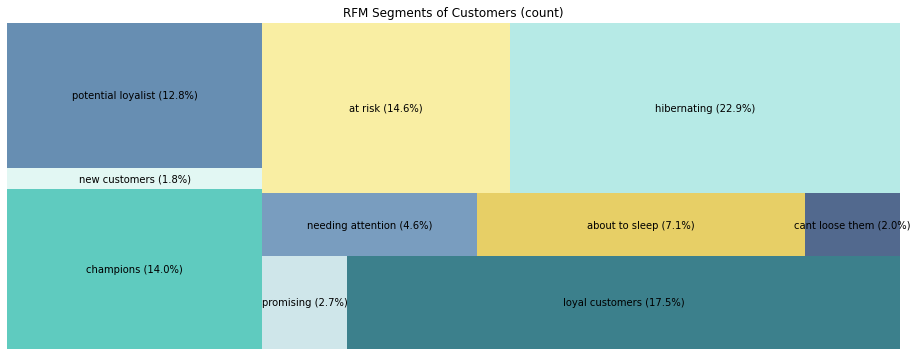

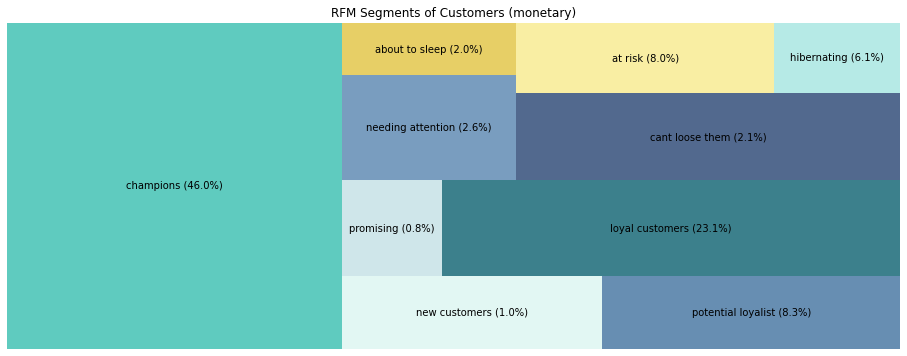

In [18]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()